### Project 5 - Identify Fraud from Enron Email
Jeremy Crantek<br>
Western Governor's University<br>
September 29, 2020

In [1]:
#!/usr/bin/env python -W ignore::DeprecationWarning
# import libraries    
import sys
import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
from tester import dump_classifier_and_data
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../tools/")

In [2]:
#Let's show those graphs in our notebook
%matplotlib inline

#Let's display all those columns in our notebook
pd.set_option('display.max_columns', None)

In [3]:
### Load the dictionary containing the dataset into data_dict
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#Convert the data_dict to a dataframe (df) to explore what's in it    
df = pd.DataFrame.from_dict(data_dict, orient='index')

# Let's see what is in this dataset
df.describe().transpose()

,count,unique,top,freq
salary,146,95,NaN,51
to_messages,146,87,NaN,60
deferral_payments,146,40,NaN,107
total_payments,146,126,NaN,21
exercised_stock_options,146,102,NaN,44
bonus,146,42,NaN,64
restricted_stock,146,98,NaN,36
shared_receipt_with_poi,146,84,NaN,60
restricted_stock_deferred,146,19,NaN,128
total_stock_value,146,125,NaN,20


In [4]:
# We have null values (unique count vs count), so let's replace them with 0.0
df.fillna(0, inplace=True)
df.replace(to_replace='NaN', value=0.0, inplace=True)

## Remove Outliers

In order to remove the outliers we must find them first. A simple scatterplot ought to show us how our data is grouped.

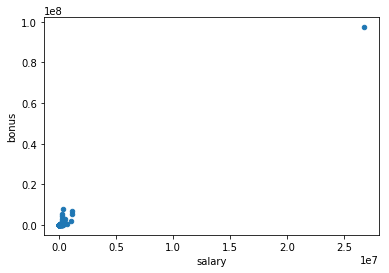

In [5]:
df.plot.scatter(x = "salary", y = "bonus")

That's quite the outlier in that scatterplot. Let's find out what it is and remove it so we can get a better look at our overall data grouping.

In [6]:
# What is the outlier?
df['salary'].sort_values(ascending = False).head()

TOTAL                 26704229.0
SKILLING JEFFREY K     1111258.0
LAY KENNETH L          1072321.0
FREVERT MARK A         1060932.0
PICKERING MARK R        655037.0
Name: salary, dtype: float64

In [7]:
print "The outlier is {0}.".format(df['salary'].idxmax())

The outlier is TOTAL.


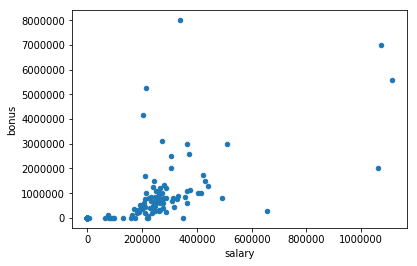

In [8]:
#Now let's remove or drop TOTAL so our data is distributed better
df.drop('TOTAL', inplace = True)
# Update our scatterplot
df.plot.scatter(x = "salary", y = "bonus")

### Creating New Features

The Enron dataset is used mostly to find those people of interest who were essentially outliers in their own organization. Determining who sent emails to them (to_messages) and from them (from_messages) are major indicators to those exploring this data for insights.

To find that we'll compare a person's overall email count to those that were sent to/from a person of interest using 2 new features:

<b>ratio_from_poi <br>
ratio_to_poi

In [9]:
### New features called ratio_from_poi and ratio_to_poi
df["ratio_from_poi"] = df["from_poi_to_this_person"].divide(df["to_messages"], fill_value=0.0) 
df["ratio_to_poi"] = df["from_this_person_to_poi"].divide(df["from_messages"], fill_value=0.0)

df['shared_receipt_poi_ratio'] = df['shared_receipt_with_poi'].divide(df['to_messages'], fill_value=0.0)

df['bonus_to_salary'] = df['bonus'].divide(df['salary'], fill_value=0.0)
df['bonus_to_total'] = df['bonus'].divide(df['total_payments'], fill_value=0.0)

df["ratio_from_poi"] = df["ratio_from_poi"].fillna(0.0)
df["ratio_to_poi"] = df["ratio_to_poi"].fillna(0.0)

df["shared_receipt_poi_ratio"] = df["shared_receipt_poi_ratio"].fillna(0.0)

df["bonus_to_salary"] = df["bonus_to_salary"].fillna(0.0)
df["bonus_to_total"] = df["bonus_to_total"].fillna(0.0)

In [10]:
# this new feature is working
df['ratio_from_poi'].head()

ALLEN PHILLIP K       0.016196
BADUM JAMES P         0.000000
BANNANTINE JAMES M    0.068905
BAXTER JOHN C         0.000000
BAY FRANKLIN R        0.000000
Name: ratio_from_poi, dtype: float64

In [11]:
# and so is this one
df['ratio_to_poi'].head()

ALLEN PHILLIP K       0.029613
BADUM JAMES P         0.000000
BANNANTINE JAMES M    0.000000
BAXTER JOHN C         0.000000
BAY FRANKLIN R        0.000000
Name: ratio_to_poi, dtype: float64

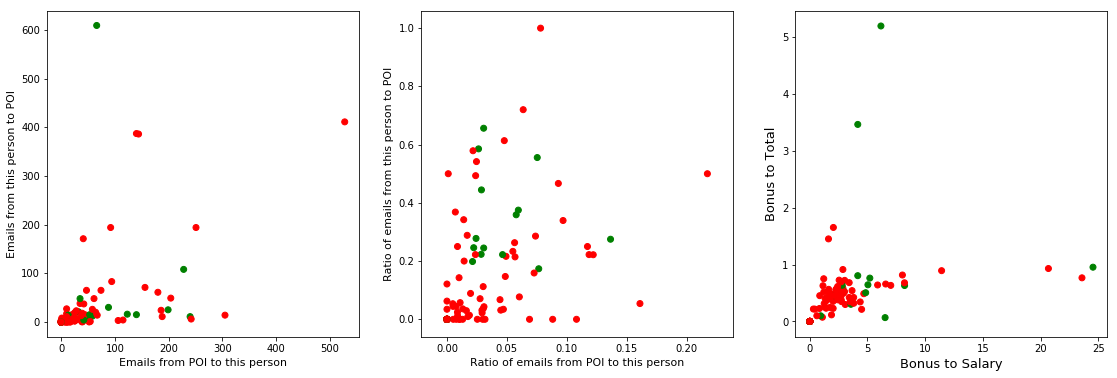

In [12]:
### Let's add the new features to our existing plot to see how they fit
figure, (axes1, axes2, axes3) = plt.subplots(nrows=1, ncols=3, figsize=(19,6))

colors = np.where(df["poi"] == 1, 'green', 'o')
colors[df["poi"] == 0] = 'red'

axes1.scatter(df["from_poi_to_this_person"], df["from_this_person_to_poi"], color=colors)
axes1.set_xlabel("Emails from POI to this person", fontsize=11)
axes1.set_ylabel("Emails from this person to POI", fontsize=11)

axes2.scatter(df["ratio_from_poi"], df["ratio_to_poi"], color=colors)
axes2.set_xlabel("Ratio of emails from POI to this person", fontsize=11)
axes2.set_ylabel("Ratio of emails from this person to POI", fontsize=11)

axes3.scatter(df["bonus_to_salary"], df["bonus_to_total"], color=colors)
axes3.set_xlabel("Bonus to Salary", fontsize=13)
axes3.set_ylabel("Bonus to Total", fontsize=13)

plt.show()

## To Scale or Not to Scale

There are several algorithms that could be used in analyzing the Enron Data. If we were using *K-Means* or *Support Vector Machine (SVM)*, we would need to scale the data due to the distance between the points. It would only take one large feature to offset the other features when calculating the distance.

To avoid any feature scaling, let's using the *Naive Bayes* and *Decision Tree* algorithms.

### Selecting Features

When selecting features, we want to eliminate any weak features, those that don't contain a lot of information, and keep the strongest features. We also want a minimal amount of features as to let the algorithms work their 'magic' to the the best of their abilities.

In [13]:
# We must convert the boolean type in the poi column to float values in order
# to classify them
df["poi"] = df["poi"].astype(float)

features_list = ['to_messages', 'deferral_payments', 'bonus_to_salary',
                 'loan_advances', 'bonus_to_total', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses',
                 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
                 'other', 'from_this_person_to_poi', 'long_term_incentive',
                 'shared_receipt_poi_ratio', 'restricted_stock', 'director_fees',
                 'ratio_from_poi', 'ratio_to_poi']

labels = df["poi"].tolist()
features = df[features_list].values.tolist()

from sklearn.feature_selection import SelectKBest, f_classif
# Using the f_classif function from SelectKBest to score our features list
selector = SelectKBest(f_classif, k = 20)
selector.fit(features, labels)

#scores = -np.log10(selector.pvalues_)
scores = selector.scores_

unsorted_pairs = zip(features_list, scores)
sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
sorted_pairs

[('exercised_stock_options', 25.3801052997602),
 ('total_stock_value', 24.752523020258508),
 ('bonus_to_total', 21.262083416531794),
 ('ratio_to_poi', 16.873870264572993),
 ('deferred_income', 11.732698076065354),
 ('bonus_to_salary', 11.127882811026838),
 ('long_term_incentive', 10.222904205832778),
 ('shared_receipt_poi_ratio', 9.49145795071451),
 ('restricted_stock', 9.480743203478934),
 ('loan_advances', 7.301406651536036),
 ('expenses', 6.3746144901977475),
 ('from_poi_to_this_person', 5.446687483325353),
 ('other', 4.263576638144469),
 ('ratio_from_poi', 3.293828632029562),
 ('from_this_person_to_poi', 2.470521222656084),
 ('director_fees', 2.0893098994318806),
 ('to_messages', 1.7516942790340737),
 ('deferral_payments', 0.20970584227026345),
 ('from_messages', 0.1587702392129193),
 ('restricted_stock_deferred', 0.0644770280387286)]

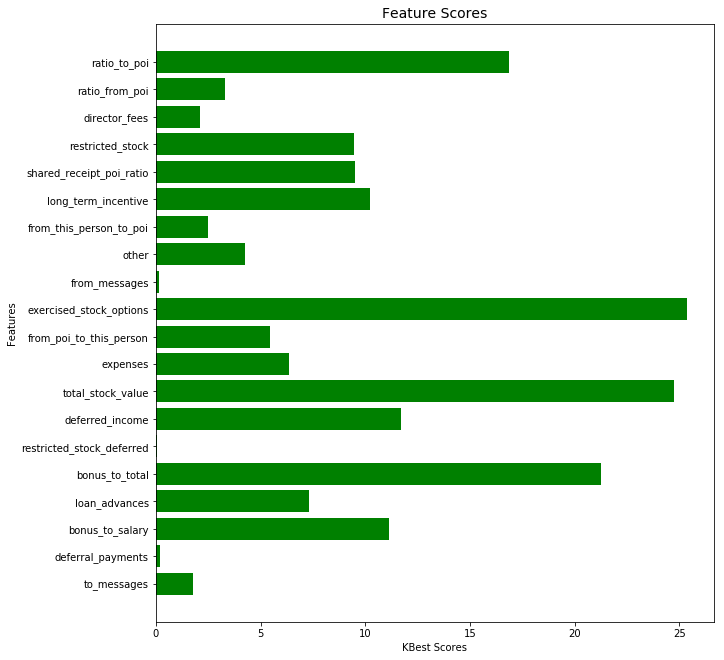

In [14]:
# A bar graph to show the scores side by side
figure, axes = plt.subplots(figsize=(10,11))
axes.barh(features_list, width = scores, color = "green")
axes.set_title("Feature Scores", fontsize = 14)
axes.set_xlabel("KBest Scores")
axes.set_ylabel("Features")
plt.show()

### Removing the lowest scored features

After reviewing the graph above, we can elimiate quite a few features from our list. Essentially any feature that scored less than 2 can be removed.

In [15]:
features_list = ["bonus_to_total", "loan_advances", "bonus_to_salary", "deferred_income", 
"total_stock_value", "exercised_stock_options", "long_term_incentive",
"shared_receipt_poi_ratio", "restricted_stock", "ratio_to_poi"]

print "The number of features we're now using is {0}.".format(len(features_list))

The number of features we're now using is 10.


In [16]:
labels = df["poi"].tolist()
features = df[features_list].values.tolist()

### Applying Algorithms

We'll be using Decision Tree, Naive Bayes, Random Forest, AdaBoost and K-Nearest Neighbors

In [17]:
# Extract features and labels from dataset for local testing
from sklearn.model_selection import train_test_split, GridSearchCV 

# Split the data into 70% train data and 30% test data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 65)

### Decision Tree Classifier

In [18]:
# import the decisiontreeclassifier from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# apply some random parameters
clf = DecisionTreeClassifier(max_depth = 5, random_state = 45)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)

# Now let's see those metrics
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print ("Decision Tree Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))
print "F1 Score: " + str(f1_score(labels_test,pred))

Decision Tree Classifier: 
Accuracy: 0.8181818181818182
Precision Score: 0.42857142857142855
Recall Score: 0.42857142857142855
F1 Score: 0.42857142857142855


### Naive Bayes Classifier

In [19]:
# import NaiveBayes from sklearn
from sklearn.naive_bayes import GaussianNB

# default parameters
clf = GaussianNB()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)

# Now let's see those metrics
accuracy = accuracy_score(labels_test,pred)
print("Naive Bayes Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))
print "F1 Score: " + str(f1_score(labels_test,pred))

Naive Bayes Classifier: 
Accuracy: 0.8636363636363636
Precision Score: 0.6
Recall Score: 0.42857142857142855
F1 Score: 0.5


### Random Forest Classifier

In [20]:
# import RandomForest from sklearn
from sklearn.ensemble import RandomForestClassifier

# put in some random parameters
clf = RandomForestClassifier(random_state = 45, n_estimators = 150)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test,pred)

# Now let's see those metrics
print ("Random Forest Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))
print "F1 Score: " + str(f1_score(labels_test,pred))

Random Forest Classifier: 
Accuracy: 0.8409090909090909
Precision Score: 0.5
Recall Score: 0.14285714285714285
F1 Score: 0.22222222222222224


### Ada Boost Classifier

In [21]:
# import AdaBoost from sklearn
from sklearn.ensemble import AdaBoostClassifier

# default parameters
clf = AdaBoostClassifier()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test,pred)

# Now let's see those metrics
print ("AdaBoost Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))
print "F1 Score: " + str(f1_score(labels_test,pred))

AdaBoost Classifier: 
Accuracy: 0.8409090909090909
Precision Score: 0.5
Recall Score: 0.42857142857142855
F1 Score: 0.4615384615384615


### K-Nearest Neighbors Classifier

In [22]:
# import KNN from sklearn
from sklearn.neighbors import KNeighborsClassifier

# parameter of 3
clf = KNeighborsClassifier(3)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test,pred)

# Now let's see those metrics
print ("K-Nearest Neighbors Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))
print "F1 Score: " + str(f1_score(labels_test,pred))

K-Nearest Neighbors Classifier: 
Accuracy: 0.8181818181818182
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0


### Hyperparameter Tuning AdaBoost Model

In order to tune the hyperparameters there are several things that we need to do. First we need to initiate our AdaBoostClassifier with some basic settings. Then we need to create our search grid with the hyperparameters. We will do this by using GridSearchCV. GridSearchCV allows us to run our algorithm several times using the parameters we suggest. For this grid, there are two hyperparameters that we will set and they are *number of estimators (n_estimators)* and the *learning rate* (learning_rate).

*Number of estimators* has to do with how many trees are developed. The *learning rate* indicates how each tree contributes to the overall results. We have to place in the grid several values for each of these. Once we set the arguments for the AdaBoostClassifier and the search grid, we then combine all this information into an object called *search*. I used the accuracy parameter from scoring to find a higher accuracy than our initial 80%.

In [23]:
# Setting AdaBoostClassifier to an object called ada, necessary for GridSearchCV to work
ada = AdaBoostClassifier()

# test parameters to feed the GridsearchCV and return the highest AdaBoost accuracy score
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}

# Apply StratifiedShuffleSplit to run our numerous algorithm folds
from sklearn.model_selection import StratifiedShuffleSplit

# Running 3 random folds, with a test size of 30%
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=70)
search = GridSearchCV(estimator = ada,param_grid = search_grid, scoring = 'accuracy', n_jobs = 1, cv=cv)

In [24]:
# This will return the overall best parameters to use in another AdaBoost algorithm 
# to return the highest accuracy score
search.fit(features,labels)
search.best_params_

{'learning_rate': 0.01, 'n_estimators': 500}

In [25]:
# This is the best possible score using the parameters we fed the GridSearch
search.best_score_

0.9242424242424242

Now we can see that setting the learning rate to 0.01 and the estimators to 500 will return the highest accuracy for our model. It can potentially return 92% which is much higher than our original AdaBoost algorithm but now with more consistent results. 

In [26]:
# Now we'll apply our newly fine tuned parameters to an Adaboost algorithm
from sklearn.model_selection import cross_val_score
# Using cross validation to find the mean of a few splits of our data
score=np.mean(cross_val_score(ada,features, labels,scoring='accuracy',cv=cv,n_jobs=1))
score

0.8863636363636364

Using cross validation to find the mean accuracy of a section of our data returns a much improved 88% accuracy to our dataset. Now let's run our initial AdaBoost Classifier, only this time using our hyperparameters. My prediction is we will see an increase in all of our metrics, accuracy included.

In [27]:
# Our hypertuned parameters are now applied
clf = AdaBoostClassifier(learning_rate = 0.01, n_estimators = 500)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test,pred)

# Now let's see those metrics
print "AdaBoost Classifier: "
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))
print "F1 Score: " + str(f1_score(labels_test,pred))

AdaBoost Classifier: 
Accuracy: 0.8636363636363636
Precision Score: 0.6666666666666666
Recall Score: 0.2857142857142857
F1 Score: 0.4


### Conclusion

After tuning our Adaboost classifier using our hyperparameters, we received a 4% boost in our accuracy using our feature set. This means we could potentially identify a POI from our dataset with an 88% chance of choosing whether the POI was true. While all of our metrics increased as well, there is still room for improvement. A similar process from hypertuning parameters could be set up to increase precision, recall and our f1 score. Right now our precision of 66% means we'd be finding 33% false positive flags which doesn't sit well with me. I also think there are other features we could explore and I bet there are more outliers in that data as well.